In [36]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path) #what does this do? this is a function that takes a path and returns a list of files in that path

print(findFiles('data/names/*.txt'))



['data/names/Polish.txt', 'data/names/English.txt', 'data/names/Russian.txt', 'data/names/Vietnamese.txt', 'data/names/Scottish.txt', 'data/names/Korean.txt', 'data/names/Chinese.txt', 'data/names/German.txt', 'data/names/Italian.txt', 'data/names/French.txt', 'data/names/Dutch.txt', 'data/names/Portuguese.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Arabic.txt', 'data/names/Czech.txt', 'data/names/Japanese.txt']


In [37]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;" #what does this do? this is a string of all the letters in the alphabet and some punctuation
n_letters = len(all_letters)# why is this 57? this is the number of letters in the alphabet and punctuation

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) #NFD is a normalization form that decomposes a character by canonical decomposition
        if unicodedata.category(c)!= 'Mn' #Mn is a category of nonspacing marks
        and c in all_letters #this line is checking if the character is in the string of all letters
    )
    
print(unicodeToAscii('Ślusàrski'))

#Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

Slusarski


In [38]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0] #this is splitting the file name from the path and then splitting the file name from the extension
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
    

In [39]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [40]:
#To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

# To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.

# That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.


import torch
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1,n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line),1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())



tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
torch.Size([5, 1, 56])


In [41]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN,self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1) #why dim=1? this is the dimension along which the softmax is applied
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)#why this dimension? this is the dimension along which the tensors are concatenated
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

        
    def initHidden(self):
        return torch.zeros(1,self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [42]:
input = letterToTensor('A')
hidden = torch.zeros(1,n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don’t want to be creating a new Tensor for every step, so we will use lineToTensor instead of letterToTensor and use slices. This could be further optimized by pre-computing batches of Tensors.

In [43]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0],hidden)
print(output)

tensor([[-2.8942, -2.8831, -2.7738, -2.9704, -2.8909, -2.8563, -2.8616, -2.9327,
         -2.8287, -2.9347, -2.9138, -2.7423, -2.9745, -2.9044, -2.9604, -2.9244,
         -2.8867, -2.9280]], grad_fn=<LogSoftmaxBackward0>)


Preparing for Training

Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use Tensor.topk to get the index of the greatest value

In [44]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1) #what is topk? this is a function that returns the k largest elements of the given input tensor along a given dimension
    category_i = top_i[0].item() #what is item? this is a function that returns the value of this tensor as a standard python number# and what is top_i[0]? this is the first element of the tensor
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Portuguese', 11)


In [45]:
# We will also want a quick way to get a training example (a name and its language):
import random
def randomChoice(l):
    return l[random.randint(0, len(l)-1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)],dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Greek / line = Bursinos
category = Irish / line = Doherty
category = Scottish / line = Whyte
category = Dutch / line = Alst
category = Japanese / line = Chikamatsu
category = Spanish / line = Ibarra
category = Portuguese / line = Madeira
category = Dutch / line = Segers
category = Japanese / line = Nagasawa
category = Russian / line = Harlashenkov


Training the Network

Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it’s wrong.

For the loss function nn.NLLLoss is appropriate, since the last layer of the RNN is nn.LogSoftmax.

In [46]:
criterion = nn.NLLLoss() #what is NLLLoss? this is a negative log likelihood loss function


Each loop of training will:

    Create input and target tensors

    Create a zeroed initial hidden state

    Read each letter in and

    Keep hidden state for next letter

    Compare final output to target

    Back-propagate

    Return the output and loss


In [47]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden =  rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    
    return output, loss.item() #what is item? this is a function that returns the value of this tensor as a standard python number
    

In [48]:
# training with some example
import time
import math

n_iters = 500000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s-=m*60
    return '%dm %ds' % (m,s)

start = time.time()

for iter in range(1, n_iters+1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss+=loss

    # Print iter number, loss, name and guess
    if iter % print_every ==0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s'%(iter, iter/n_iters*100, timeSince(start),loss,line, guess, correct))
        
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss/plot_every)
        current_loss = 0
        

5000 1% (0m 4s) 3.0242 Senmatsu / Greek ✗ (Japanese)
10000 2% (0m 9s) 0.9596 Bukoski / Polish ✓
15000 3% (0m 14s) 0.3276 Krakowski / Polish ✓
20000 4% (0m 19s) 1.7760 Arena / Spanish ✓
25000 5% (0m 23s) 2.0625 Karl / Dutch ✓
30000 6% (0m 28s) 0.1620 Zhelvakov / Russian ✓
35000 7% (0m 33s) 1.0396 Peeters / Dutch ✓
40000 8% (0m 37s) 1.1123 Siew / Chinese ✓
45000 9% (0m 42s) 0.8560 OHannagain / Irish ✓
50000 10% (0m 47s) 1.0141 Chermak / Czech ✓
55000 11% (0m 51s) 0.4474 Huynh / Vietnamese ✓
60000 12% (0m 56s) 0.6211 Luu / Vietnamese ✓
65000 13% (1m 1s) 2.1247 Santana / Spanish ✗ (Portuguese)
70000 14% (1m 5s) 3.3495 Paris / Greek ✗ (French)
75000 15% (1m 10s) 1.4245 She / Korean ✗ (Chinese)
80000 16% (1m 15s) 1.0869 Rijnder / Dutch ✓
85000 17% (1m 19s) 1.8718 Nanami / Arabic ✗ (Japanese)
90000 18% (1m 24s) 0.0494 Thao / Vietnamese ✓
95000 19% (1m 29s) 1.3127 Macon / French ✓
100000 20% (1m 33s) 0.5493 Duong / Vietnamese ✓
105000 21% (1m 38s) 1.0305 Bueren / Dutch ✓
110000 22% (1m 43s) 0.

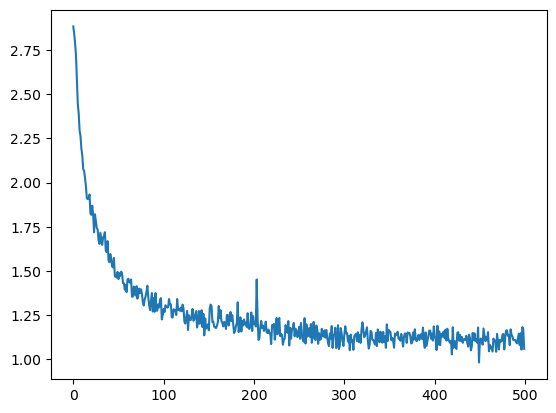

In [49]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Evaluating the Results

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop.

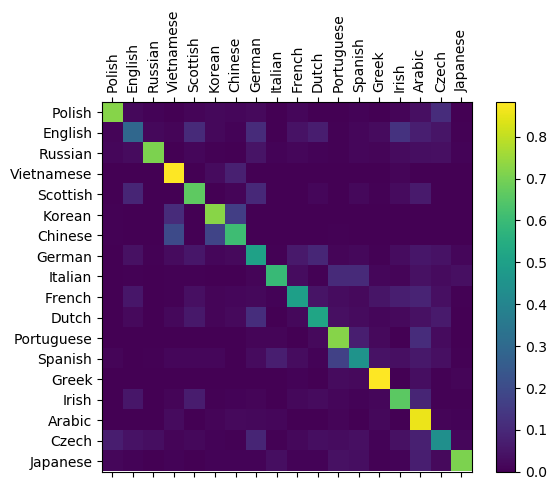

In [50]:
#confusion matrix
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i],hidden)
    
    return output


# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i]+=1
    

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i]/confusion[i].sum()
    
#Set up plot

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

#Set up axes
ax.set_xticklabels(['']+all_categories,rotation=90)
ax.set_yticklabels(['']+all_categories)

#Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()
    



Running on User Input

In [53]:
def predict(input_line, n_predictions=3):
    print('\n %s'% input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        
        #Get top N categories
        topv, topi = output.topk(n_predictions,1,True)
        predictions = []
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])
            
predict('Dovesky')
predict('Jackson')
predict('John')
predict('Ruturaj')
predict('Aydin')


 Dovesky
(-0.33) Russian
(-2.06) Czech
(-2.37) Irish

 Jackson
(-0.02) Scottish
(-4.43) English
(-5.63) Russian

 John
(-0.78) Korean
(-1.34) Irish
(-2.16) Chinese

 Ruturaj
(-0.47) Scottish
(-2.28) Greek
(-2.53) Arabic

 Aydin
(-0.47) Arabic
(-1.73) Russian
(-2.47) Irish


In [64]:
import torch.nn as nn

class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN,self).__init__()
        
        self.hidden_size = hidden_size
        # self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # self.i2o = nn.Linear(input_size + hidden_size, output_size)
        # self.softmax = nn.LogSoftmax(dim=1) #why dim=1? this is the dimension along which the softmax is applied
        self.lstm = nn.LSTM(input_size, hidden_size, 1)
        
    def forward(self, input, hidden):
        # combined = torch.cat((input, hidden), 1)#why this dimension? this is the dimension along which the tensors are concatenated
        # hidden = self.i2h(combined)
        # output = self.i2o(combined)
        # output = self.softmax(output)
        lstm_out, _ = self.lstm(input.view(len(input), 1, -1), hidden)
        return output, hidden

        
    def initHidden(self):
        return torch.zeros(1,self.hidden_size)

n_hidden = 128
# rnn = RNN(n_letters, n_hidden, n_categories)
rnn = nn.LSTM(n_letters, n_hidden, 1)


In [67]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def rnn_train(category_tensor, line_tensor):
    # hidden = rnn.initHidden()
    
    rnn.zero_grad()
    # TODO initisation of hidden state
    h_n = torch.zeros(1,n_hidden)
    c_n = torch.zeros(1,n_hidden)
    
    
    for i in range(line_tensor.size()[0]):
        output, (h_n,c_n) =  rnn(line_tensor[i],  (h_n,c_n))
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    
    return output, loss.item() #what is item? this is a function that returns the value of this tensor as a standard python number
    

In [68]:
# training with some example
import time
import math

n_iters = 500000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s-=m*60
    return '%dm %ds' % (m,s)

start = time.time()

for iter in range(1, n_iters+1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = rnn_train(category_tensor, line_tensor)
    current_loss+=loss

    # Print iter number, loss, name and guess
    if iter % print_every ==0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s'%(iter, iter/n_iters*100, timeSince(start),loss,line, guess, correct))
        
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss/plot_every)
        current_loss = 0
        

RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors